In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import dask.dataframe as dd

In [21]:
from dask.distributed import Client

In [22]:
client = Client()

E:\Anaconda3\envs\basicdata\lib\site-packages\distributed\bokeh\core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [23]:
client

Client Scheduler: tcp://127.0.0.1:53521 Dashboard: http://127.0.0.1:53524/status,Cluster Workers: 4 Cores: 4 Memory: 17.13 GB


Adding a really small blocksize to force dask to work with multiple partitions. Else it would be the same as just working with pandas

In [24]:
df_d = dd.read_csv("https://advpythonbikedask.blob.core.windows.net/bikedata/hour.csv",
                   blocksize="600KB")

We force a small blocksize to simulate how it would the partitioned between workers in case that the data size was too big for our memory

In [25]:
df_d.memory_usage().sum().compute()

2363704

In [26]:
df_d.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, instant to cnt
dtypes: object(1), float64(4), int64(12)

In [27]:
df_d.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 1.EDA

###  1.1. Identifying null values
##### According to the below the code this dataset does not have any null value.

We set up the "query" to calculate something but it's lazy evaluated until we call compute into it. IF we're working on an actualy cluster, then we can call client.persist(df_d) so that each node will do its calculation and then we can gather the results

In [28]:
nulls = df_d.isnull().sum()

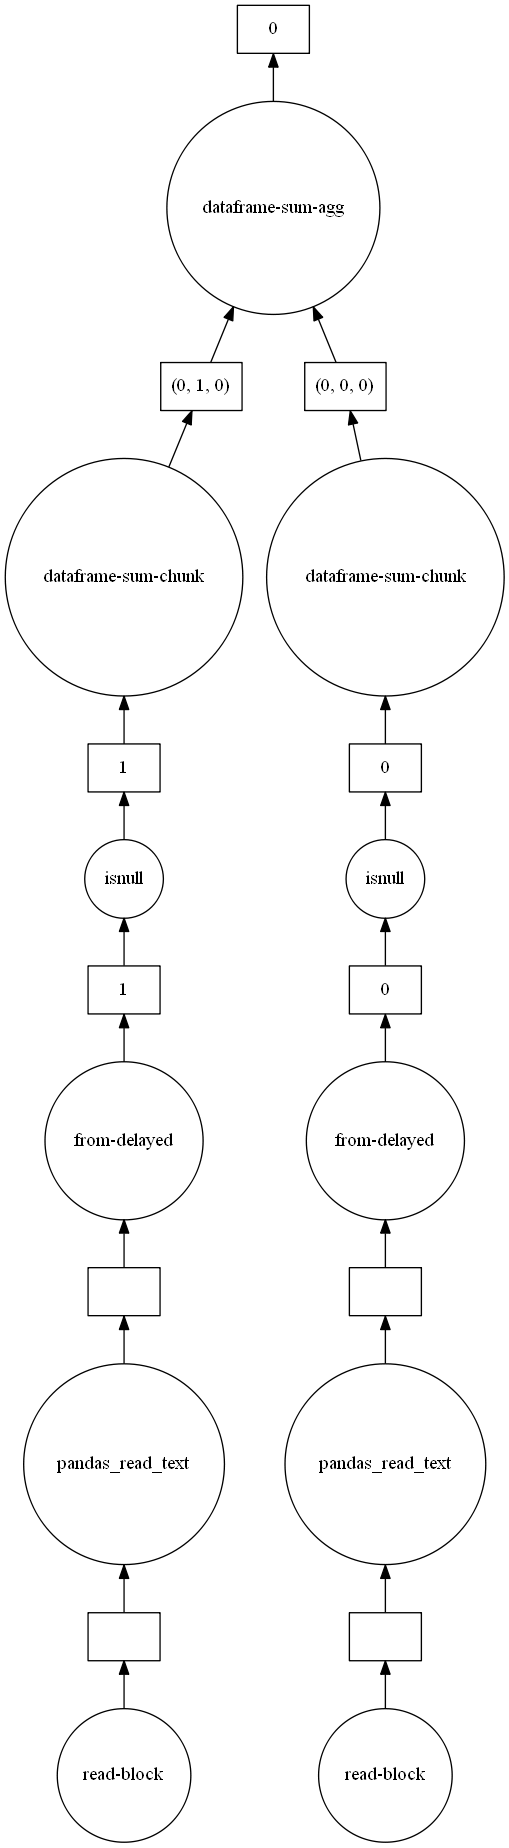

In [29]:
nulls.visualize()

In [30]:
nulls = client.persist(nulls)

then we can compute or gather-compute the results back to our machine

In [31]:
client.gather(nulls).compute()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

** Daks-persist-gather-compute Example**
This is an example to showcase how using persist can offload some computation in intermediate steps so that the final calculation is faster

In [32]:
mean_atemp = df_d.groupby('mnth')['atemp'].mean()

In [33]:
mean_atemp = client.persist(mean_atemp)

^ This is where the calculation will happen so we can have intermediate results to make subsequent queries faster

In [34]:
client.gather(mean_atemp).compute()  # This is almost instant

mnth
1     0.240676
2     0.300621
3     0.382299
4     0.457110
5     0.565662
6     0.638246
7     0.704094
8     0.651556
9     0.579344
10    0.473913
11    0.367339
12    0.326296
Name: atemp, dtype: float64

#### columns' name modification

In [35]:
df_d = df_d.rename(columns={
    "dteday": "datetime",
    "weathersit": "weather_condition",
    "cnt": "total_bike_rented",
})

### Columns' type modification:
##### Taking a look at the dataset information, we see that some columns are not in the appropriate data type. For instance, datetime is an object while it should be in date format. also we have some columns that re factor but in the dataset are presented as integer, season, year, moth, hr, holiday, workingday, weather_condition are of those.

In [36]:
df_d["datetime"] = dd.to_datetime(df_d.datetime)

In [37]:
features_to_transform = ["season", "yr", "mnth", "hr",
                         "holiday", "weekday", "workingday", "weather_condition"]

In [38]:
def type_shifter(df, features, new_type):
    """this function takes the selected features of a data frame and 
    cast them to the new_type"""
    for i in features:
        df[i] = df[i].astype(new_type)
    print(df.info())
    return df

In [39]:
df_d = type_shifter(df_d, features_to_transform, "category")

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, instant to total_bike_rented
dtypes: category(8), datetime64[ns](1), float64(4), int64(4)None


### Renaming the categorical variables' levels:

#### In the priginal dataset all the weekdays and months are presented as integer, although we have already casted them to categorical type, in order to make them more informative, we would change the levels' names:

In [40]:
df_d['weekday'] = df_d['weekday'].map({
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
})

**Here we will check which season is which numbner based on the unique months based on that season**

As we don't want to recompute everythin every time, especially if we're dealing with huge ammounts of data, we will convert a small sample on the dataset to a pandas dataframe (that would fit in memory) and then check things as we don't need all the data to determine the seasons by looking at the unique months

### Finding Seasons from the unique months

In [41]:
sample_df = df_d.sample(frac=0.2)

In [42]:
sample_df[sample_df['season'] == 1]['mnth'].unique().compute()

0     2
1    12
2     1
3     3
Name: mnth, dtype: category
Categories (4, int64): [2, 12, 1, 3]

In [43]:
sample_df[sample_df['season'] == 2]['mnth'].unique().compute()

0    5
1    4
2    6
3    3
Name: mnth, dtype: category
Categories (4, int64): [5, 4, 6, 3]

In [44]:
sample_df[sample_df['season'] == 3]['mnth'].unique().compute()

0    7
1    9
2    8
3    6
Name: mnth, dtype: category
Categories (4, int64): [7, 9, 8, 6]

In [45]:
sample_df[sample_df['season'] == 4]['mnth'].unique().compute()

0    10
1    12
2    11
3     9
Name: mnth, dtype: category
Categories (4, int64): [10, 12, 11, 9]

We can see that season 1 is winter and then Spring, Summer, Autumn come

In [46]:
df_d['season'] = df_d['season'].map(
    {1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"})

In [47]:
df_d['mnth'] = df_d['mnth'].map({
    1: "01-Jan",
    2: "02-Feb",
    3: "03-Mar",
    4: "04-Apr",
    5: "05-May",
    6: "06-Jun",
    7: "07-Jul",
    8: "08-Aug",
    9: "09-Sep",
    10: "10-Oct",
    11: "11-Nov",
    12: "12-Dec",
})

In [48]:
df_d['yr'] = df_d['yr'].map({0: '2011', 1: '2012'})

In [49]:
df_d['weather_condition'] = df_d['weather_condition'].map(
    {1: "A", 2: "B", 3: "C", 4: "D"})

### Visualization
#### In order to see if there is any specific trend in different time intervals we present the target variable over month, day and hour to get a more clear vision of the target variable evolution.

### Note: For distributed datasets we would normally sample the data to visualize as it would require all the data to come into a single machine, which if we were using enough data to warrant distribution then it would probably crash the machine. So for the sake of this example, we will sample the dataset every time we need to compute to simulate how this would work with a bigger dataset

In [50]:
# Count of records computing everything
df_d['instant'].count().compute()

17379

In [51]:
# Count by Partition (This is stupid as it can't be parallelized)
for i in range(df_d.npartitions):
    count = df_d['instant'].get_partition(i).count().compute()
    print("Partition {}: {} records".format(i, count))

Partition 0: 9122 records
Partition 1: 8257 records


So we will sample and compute before visualizing with 30% of the dataframe as an example. Normally

In [52]:
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large'}

plt.rcParams.update(params)

E:\Anaconda3\envs\basicdata\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5,1,'Hourly distribution of counts in different seasons')]

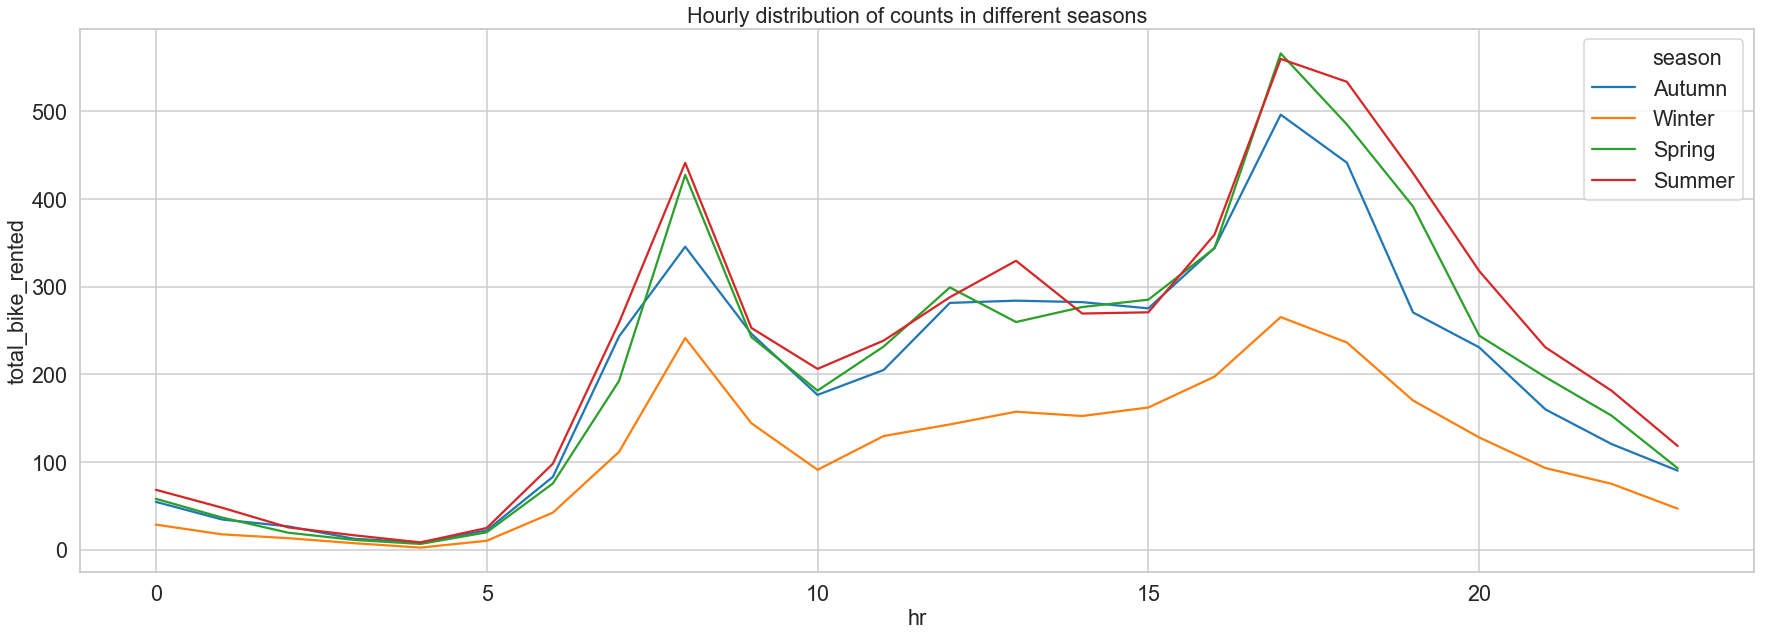

In [53]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_d[["hr", "total_bike_rented", "season"]].sample(
        frac=0.3).compute(),
    x="hr",
    y="total_bike_rented",
    hue="season",
    ax=ax,
    err_style=None
)
ax.set(title="Hourly distribution of counts in different seasons")


#### The above graph shows that bike rental business is fairly seasonal and aslo correlated with the day time.

E:\Anaconda3\envs\basicdata\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5,1,' Hourly distribution of counts over the weekdays')]

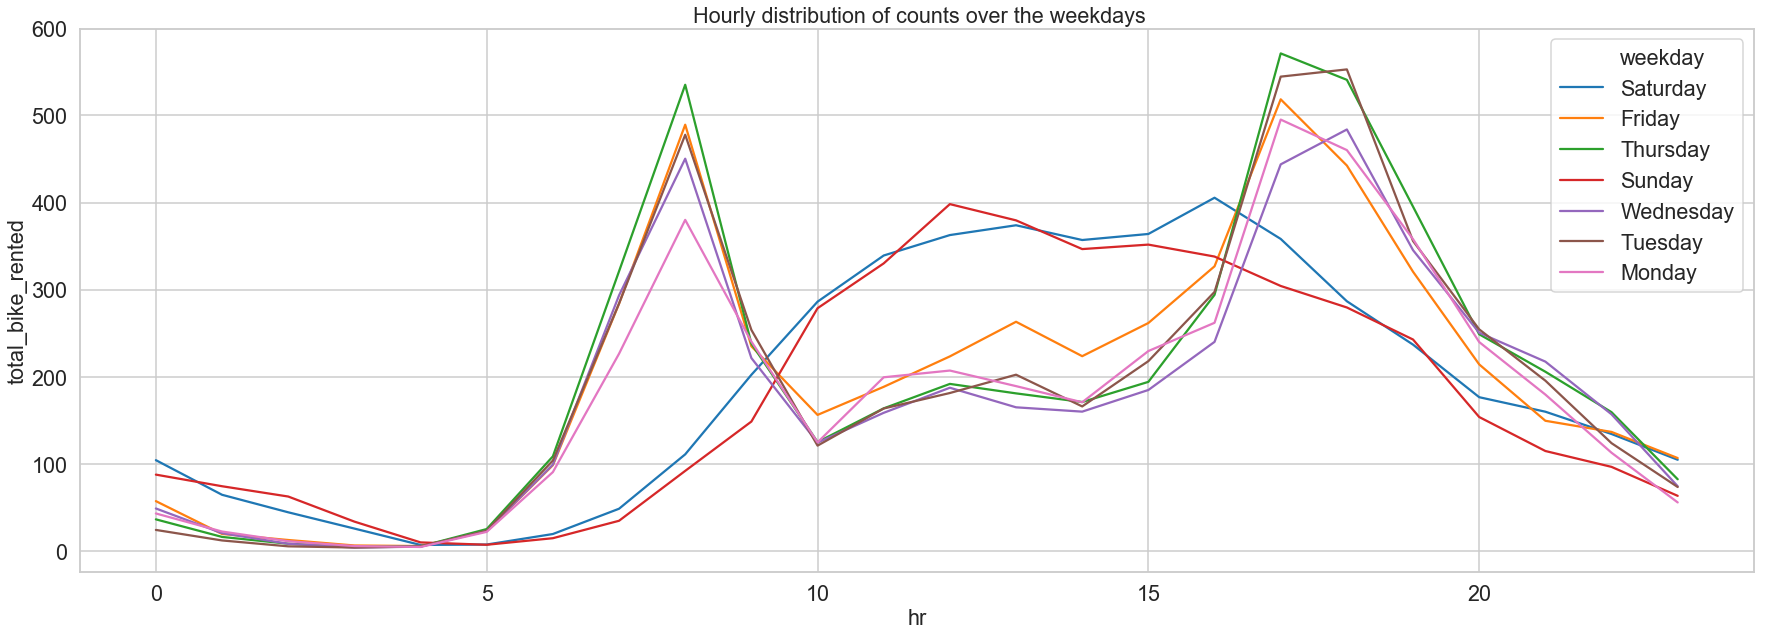

In [54]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_d[["hr", "total_bike_rented", "weekday"]].sample(
        frac=0.3).compute(),
    x="hr",
    y="total_bike_rented",
    hue="weekday",
    ax=ax,
    err_style=None


)
ax.set(title=" Hourly distribution of counts over the weekdays")

**The Above graph shows us that the behaviour is fundamentally different between weekdays and weekends where on one the pattern seems to revolve around "commuting" and over the weekds noon-earlyafternoon leisure"**

E:\Anaconda3\envs\basicdata\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0.5,1,'Monthly distribution of counts')]

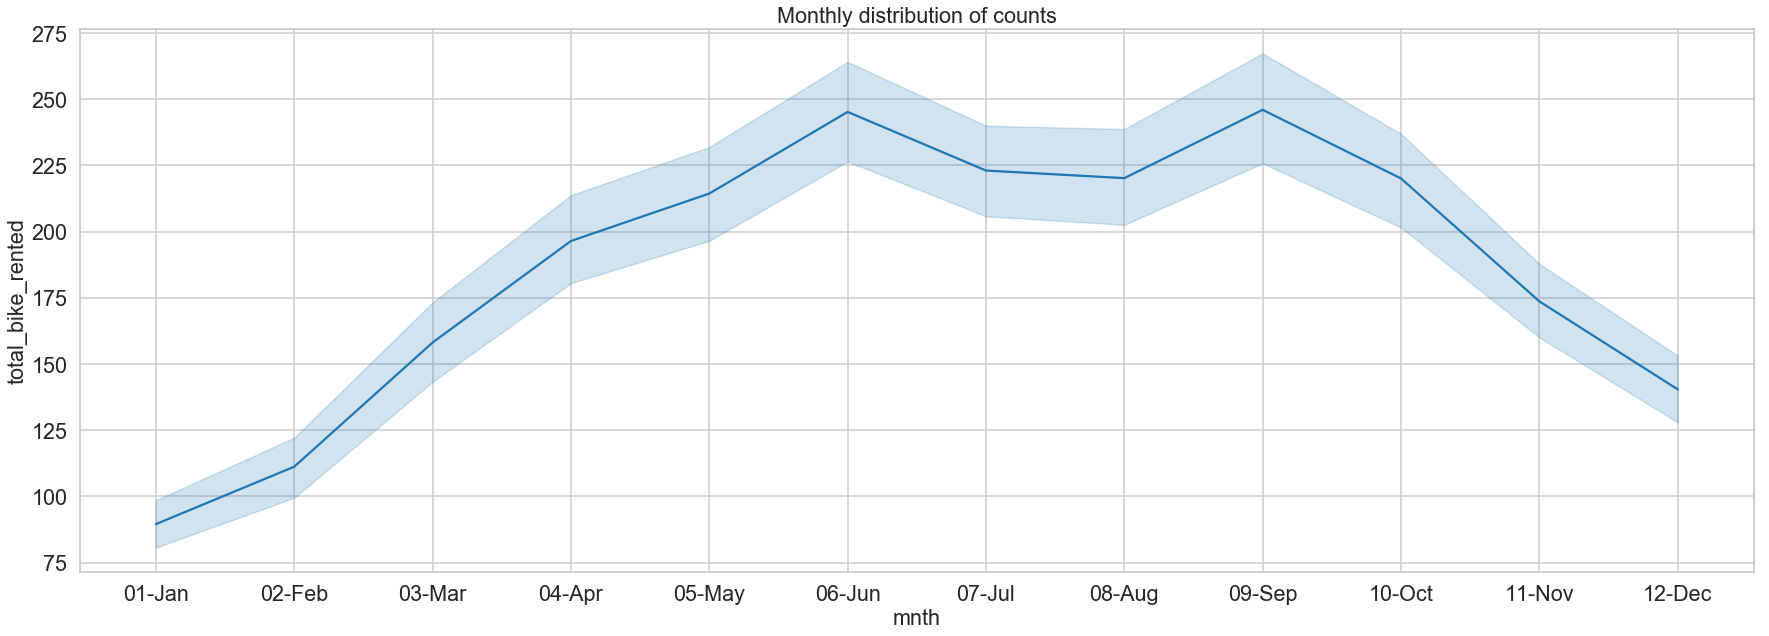

In [55]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_d[["mnth", "total_bike_rented", "yr"]].sample(frac=0.3).compute(), x="mnth", y="total_bike_rented", ax=ax,
)
ax.set(title="Monthly distribution of counts")

**We can see that the usage increases during the summer months and declines in the winter months which is logical **

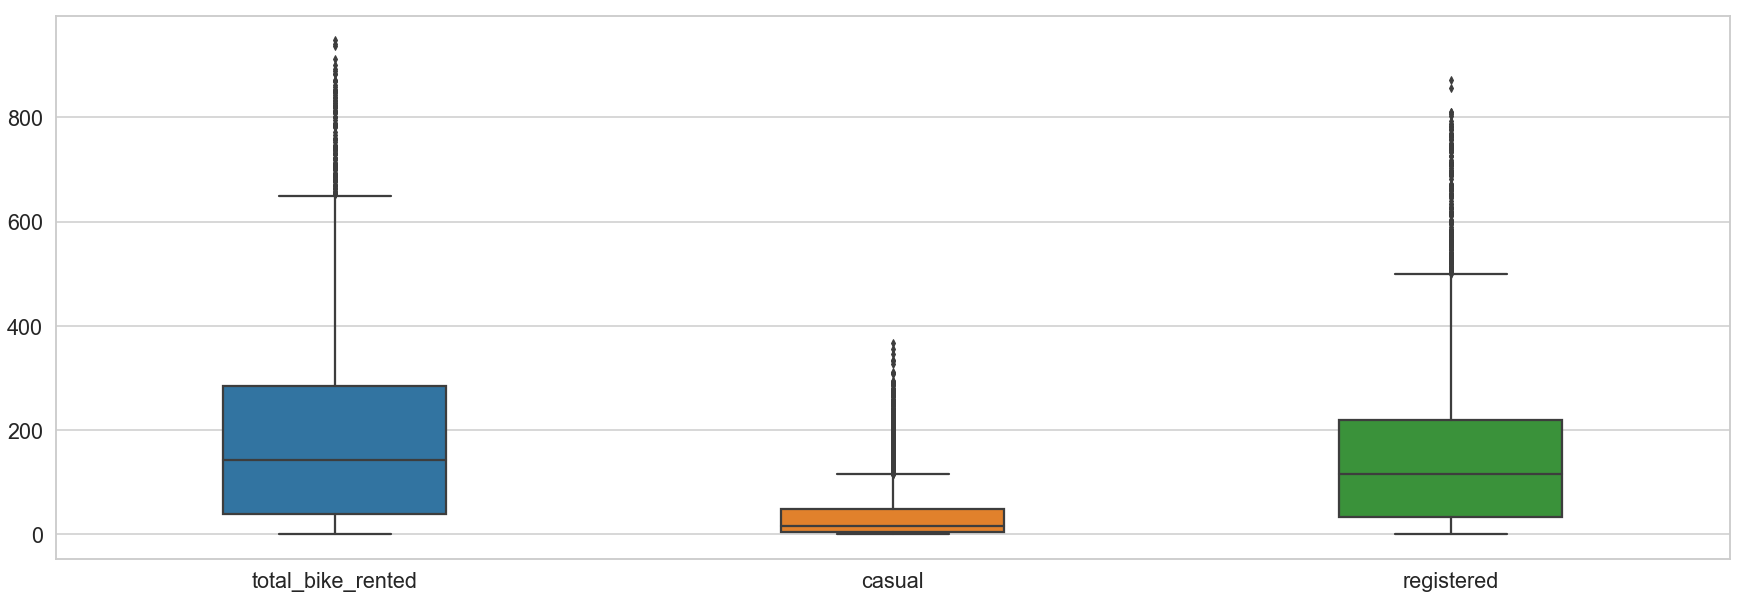

In [56]:
fig, ax = plt.subplots()
sns.boxplot(data=df_d[['total_bike_rented',
                       'casual',
                       'registered']].sample(frac=0.3).compute(), ax=ax, width=0.4)

### Features correlation

#### In order to avoid futrther error in the modeling part it is better to remove potential multicollinearity between features; therefore, we should measure the correlation coefficient between different featuers.

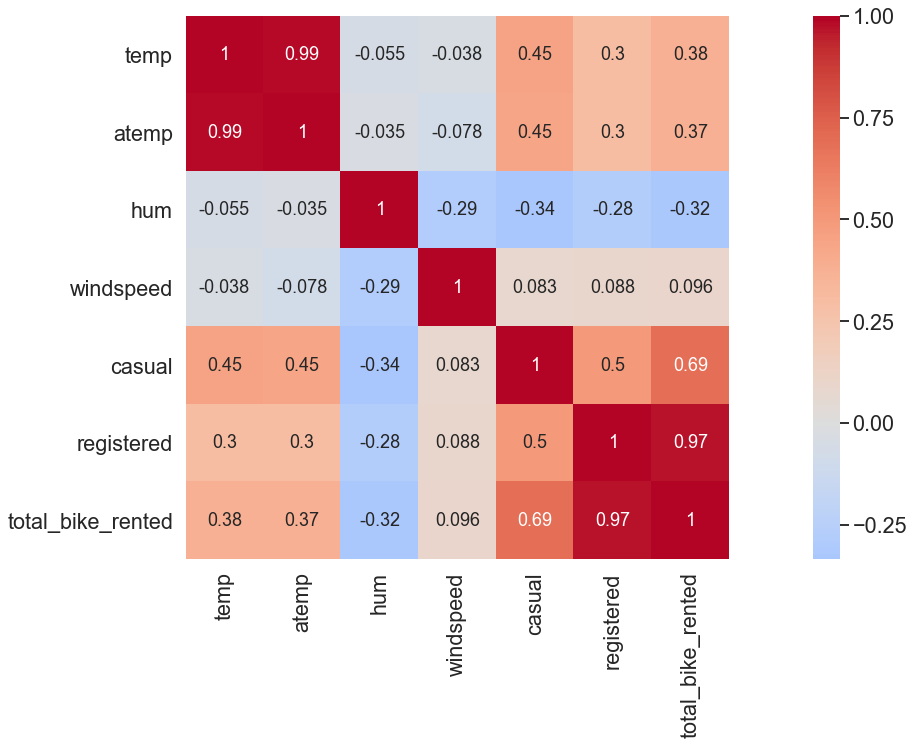

In [57]:
correlation = df_d[['temp', 'atemp', 'hum', 'windspeed', 'casual',
                    'registered', 'total_bike_rented']].sample(frac=0.3).corr().compute()
# correlation.style.background_gradient(cmap='GnBu').set_precision(2)
sns.heatmap(correlation, cmap='coolwarm', square=True, center=0, annot=True)

##### As could be seen above atemp and temp are highly correlated so we will only keep temp and drop the atem from the dataset and other side we cannot say that anu other feature is absolutely useless for Predicting the target Variable so we will keep the other numeric features.

In [58]:
df_d = df_d.drop("atemp", 1)

###### As the goal of this exercise is to predict the total_bike_rented we will remove casual and registered from the dataset

In [59]:
df_d = df_d.drop(["casual", "registered"], 1)

In [60]:
df_d.head()

,instant,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,hum,windspeed,total_bike_rented
0,1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.81,0.0,16
1,2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.80,0.0,40
2,3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.80,0.0,32
3,4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.75,0.0,13
4,5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.75,0.0,1


### Exploring numeric features:

Linear regression algorithm is highly sensitive to the numerical features distribution and also outliers. It means if numeric features are highly skewd probably the regression model would be affected in a negative way. Outliers also are quiet important, and having some outliers in a linear model could change the result totally; therefore in this part we focus on cleaning the numeric values. 

In [61]:
numeric_cols = list(df_d.select_dtypes(include=np.number).columns.values)
numeric_cols

['instant', 'temp', 'hum', 'windspeed', 'total_bike_rented']

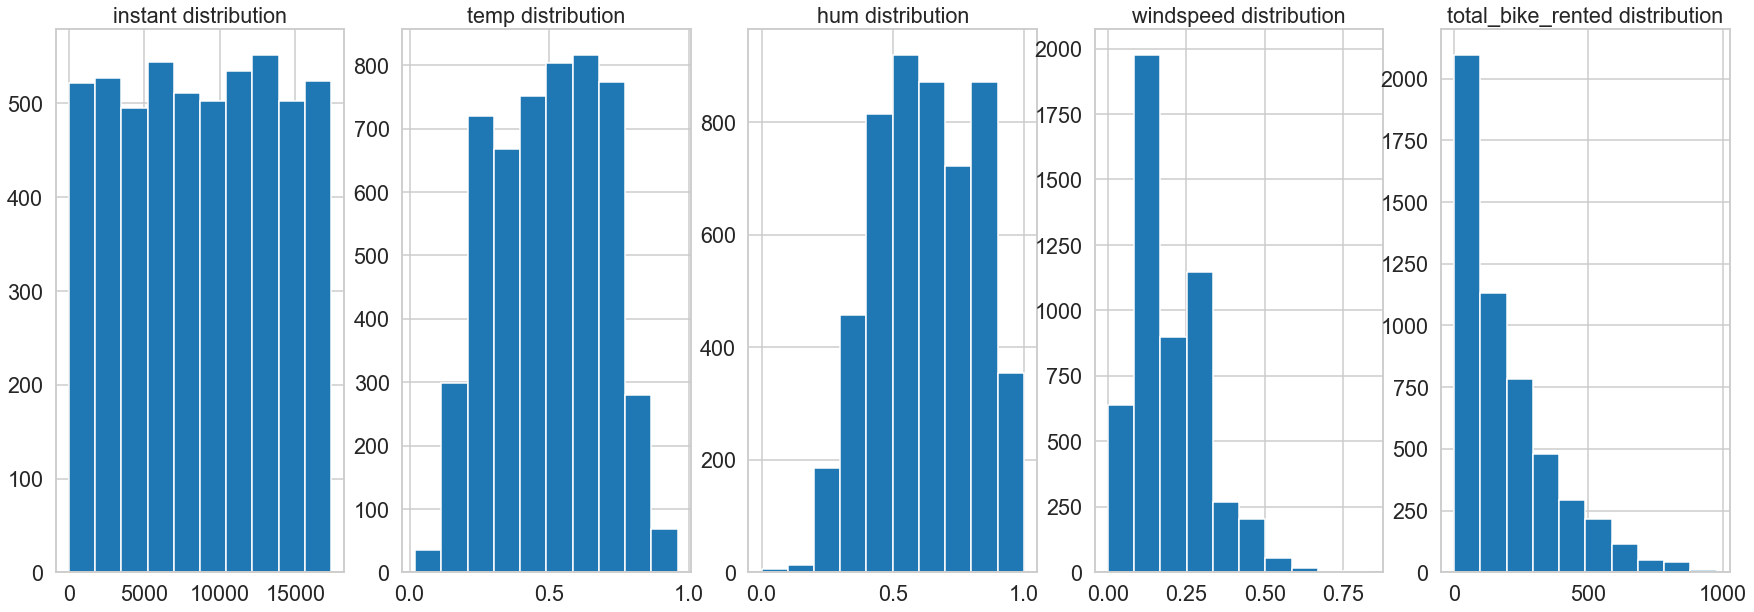

In [62]:
counter = 1
for i in df_d[numeric_cols].columns.values:
    plt.subplot(1, len(numeric_cols), counter)
    plt.hist(df_d.sample(frac=0.3)[i].compute())
    plt.title(str(i)+" " + "distribution")
    counter += 1

#### Considering the sensiticity of the Linear regression model to numeric features' skewness we try modifiy this by transforming variables with skewness higher than our threshold.

In [63]:
from scipy.stats import skew

In [64]:
for col in df_d[['windspeed', 'hum', 'temp', 'total_bike_rented']].columns.values:
    print("{} Col Skewed: {}".format(
        col, abs(skew(df_d[col].compute())) > 0.75))

windspeed Col Skewed: False
hum Col Skewed: False
temp Col Skewed: False
total_bike_rented Col Skewed: True


###### As could be seen above our target variable is highly skewed and needs to get transformed. Doing so, we take sqaure root of the target variable and the skewness would be in the acceptabel range now:

In [65]:
skew(np.log(df_d.total_bike_rented))

-0.9361009597655617

#### As log transformation in this case cannot remove the skewness we try with sqrt

In [66]:
skew(np.sqrt(df_d.total_bike_rented))

0.28644988648376024

In [67]:
df_d['total_bike_rented'] = np.sqrt(df_d.total_bike_rented)
df_d.head()

,instant,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,hum,windspeed,total_bike_rented
0,1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.81,0.0,4.000000
1,2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.80,0.0,6.324555
2,3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.80,0.0,5.656854
3,4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.75,0.0,3.605551
4,5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.75,0.0,1.000000


#### Outliers:

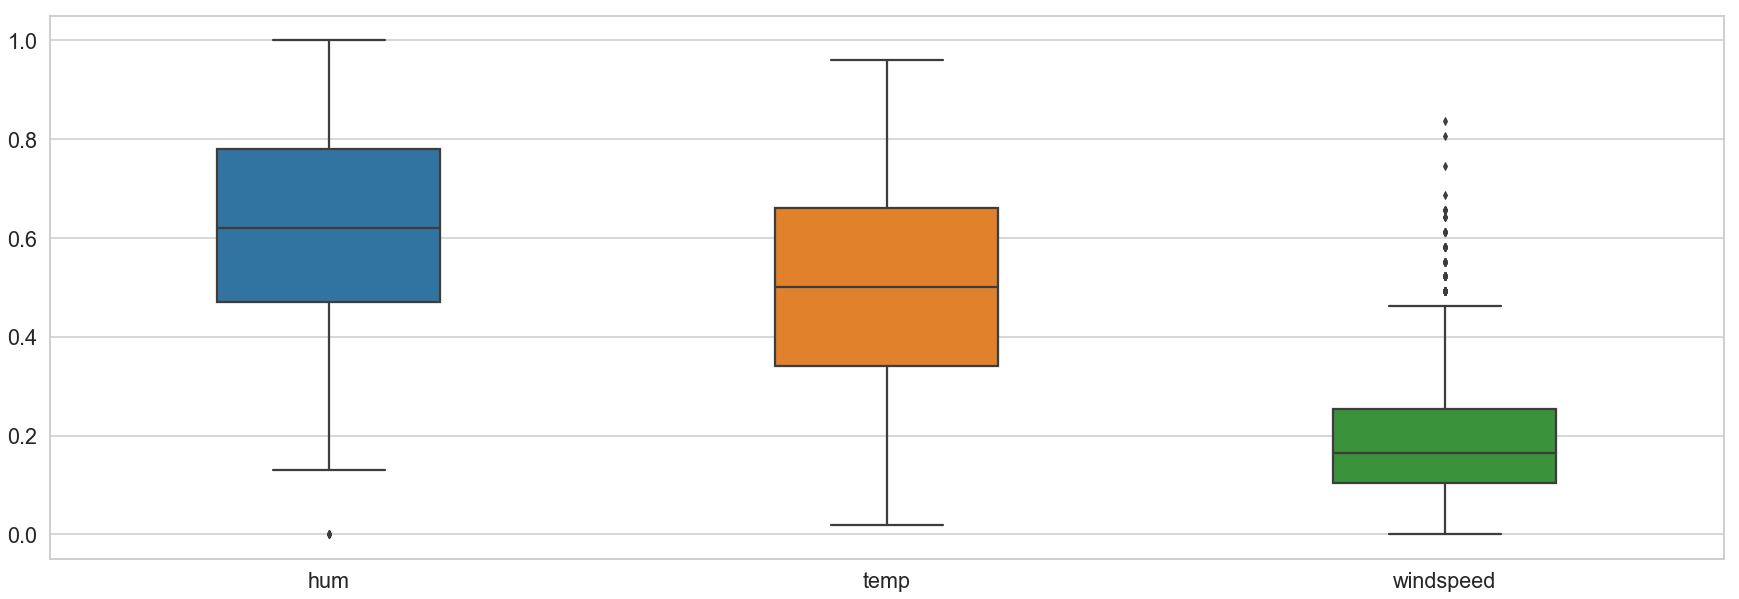

In [68]:
fig, ax = plt.subplots()
sns.boxplot(data=df_d[['hum',
                       'temp',
                       'windspeed']].sample(frac=0.3).compute(), ax=ax, width=0.4)

#### Exploring the boxplots for univariate analysis of outliers it seems that the numeric features containing outliers are hum and windspeed, however it is not enough yet to consider those points outliers. Therefore we do a multivariate analysis of windspeed and target variable to see if we can get more information. 

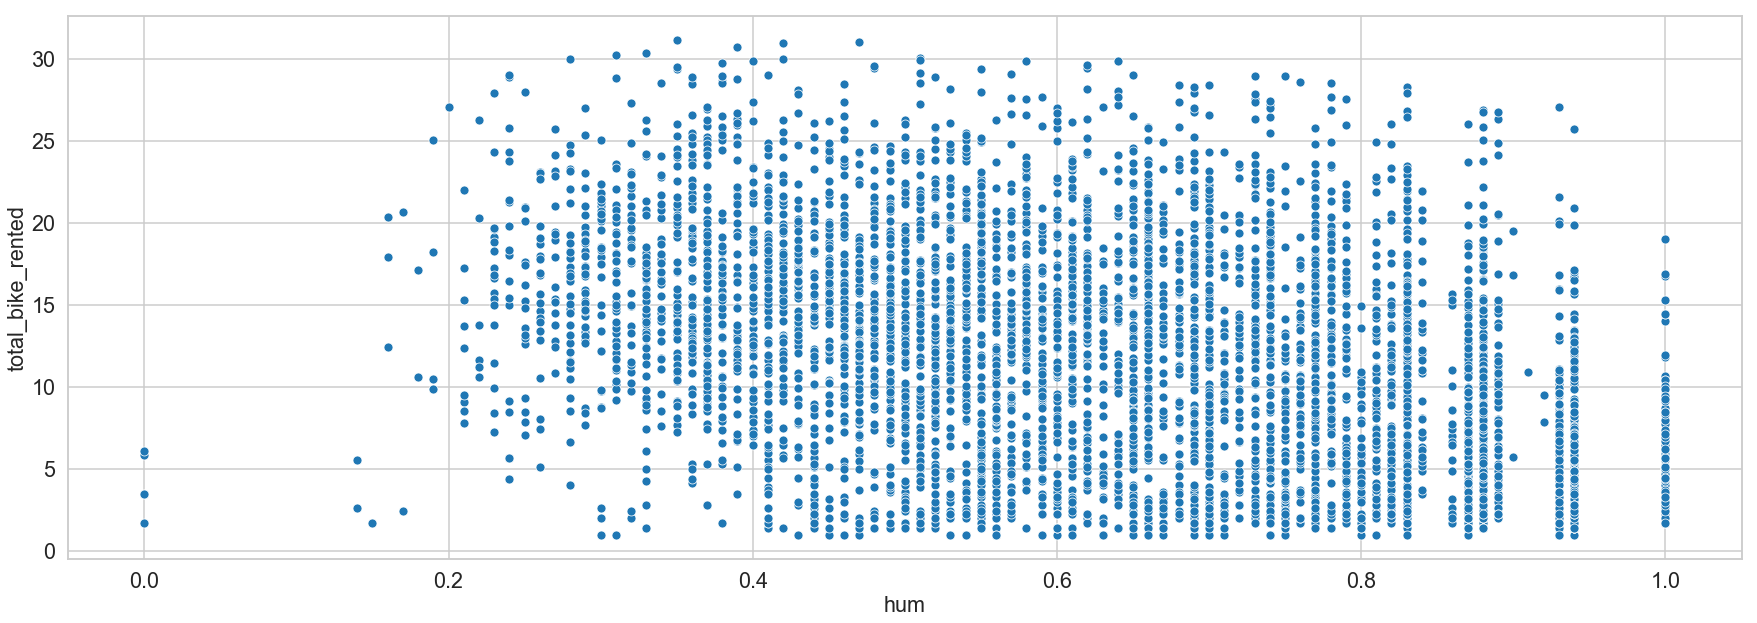

In [69]:
sns.scatterplot(data=df_d[['hum', 'total_bike_rented']].sample(frac=0.3).compute(),
                x='hum', y='total_bike_rented')

Normally we would just use lambda functions to do these transformations, but dask seemed to have some problems applying the lambda function but not if we defined the function outside. I guess this has something to do with how dask doesnt have 100% implementation on the axes

In [70]:
def hum_outliers(x):
    if x == 0:
        return 0.1
    else:
        return x

In [71]:
df_d['hum'] = df_d['hum'].apply(hum_outliers, meta='float')

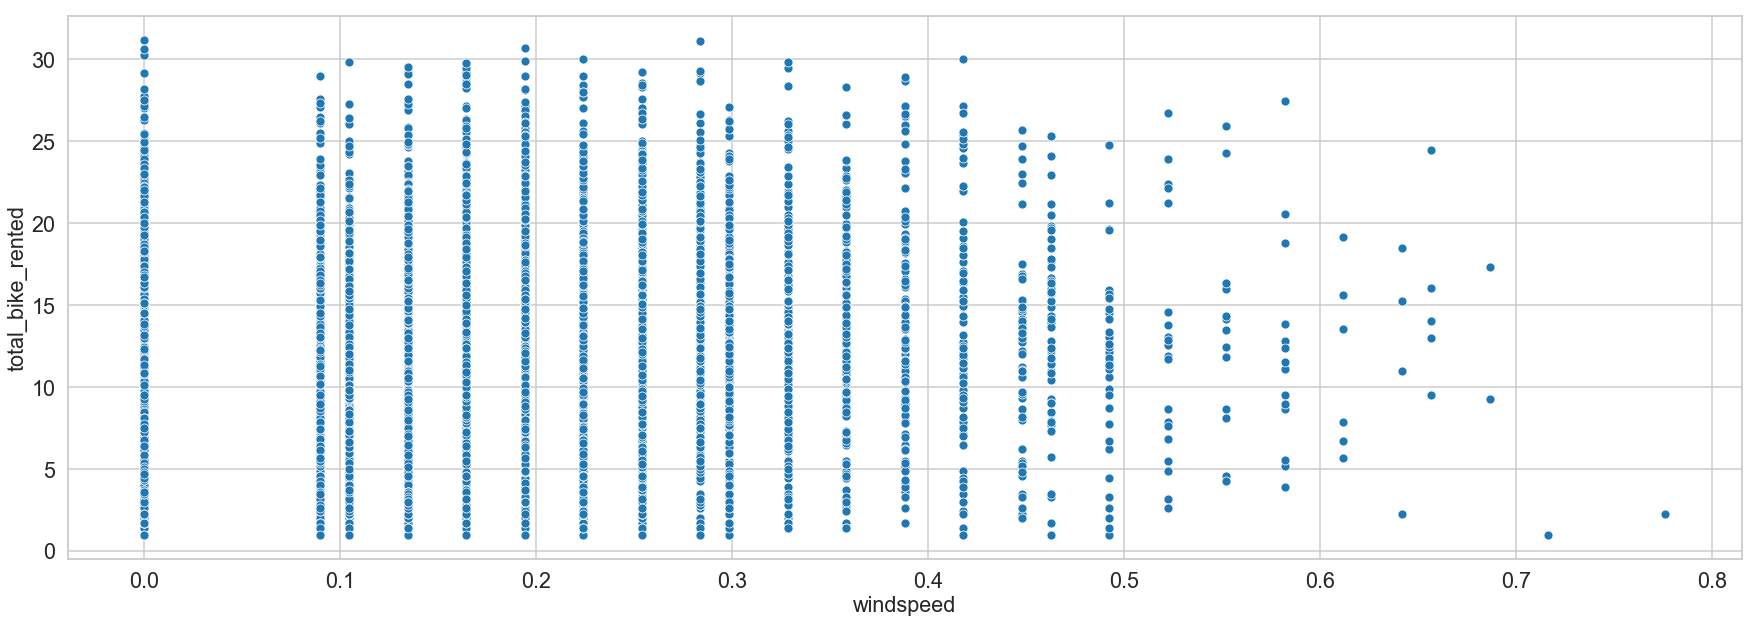

In [72]:
sns.scatterplot(data=df_d[['windspeed', 'total_bike_rented']].sample(frac=0.3).compute(),
                x='windspeed', y='total_bike_rented')

##### The above scatter plot shows that probably winspeed values over 0.7 could be consider outliers, therefore our strategy at this point is to clip the windspeed values over 0.7 to o.7.

In [73]:
def wind_outliers(x):
    if x > 0.7:
        return 0.7
    else:
        return x

In [74]:
df_d['windspeed'] = df_d['windspeed'].apply(wind_outliers, meta='float')

#### Converting categoriacal features to dummy variables.

In [75]:
df_d = df_d.categorize()

In [76]:
df_d_dummy = dd.get_dummies(df_d)

In [77]:
df_d_dummy.columns

Index(['instant', 'datetime', 'temp', 'hum', 'windspeed', 'total_bike_rented',
       'season_Winter', 'season_Spring', 'season_Summer', 'season_Autumn',
       'yr_2011', 'yr_2012', 'mnth_01-Jan', 'mnth_02-Feb', 'mnth_03-Mar',
       'mnth_04-Apr', 'mnth_05-May', 'mnth_06-Jun', 'mnth_07-Jul',
       'mnth_08-Aug', 'mnth_09-Sep', 'mnth_10-Oct', 'mnth_11-Nov',
       'mnth_12-Dec', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6',
       'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14',
       'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22',
       'hr_23', 'holiday_0', 'holiday_1', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Monday', 'weekday_Tuesday', 'weekday_Wednesday',
       'weekday_Thursday', 'weekday_Friday', 'workingday_0', 'workingday_1',
       'weather_condition_A', 'weather_condition_B', 'weather_condition_C',
       'weather_condition_D'],
      dtype='object')

Now we can see the DAG that Dask has created of all the conversions and changes and calculations we've done to our dataframe. This DAG gets run whenever we need to compute something.

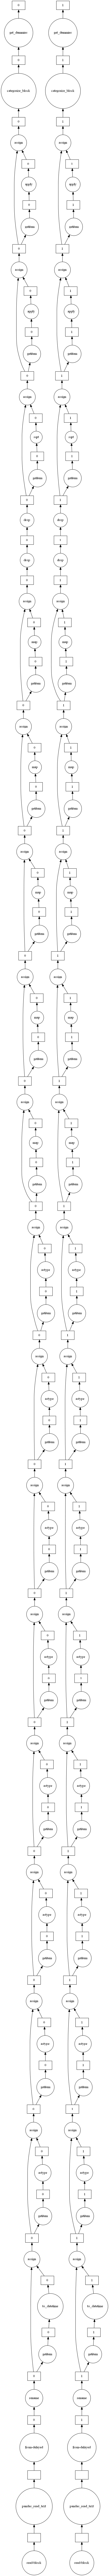

In [78]:
df_d_dummy.visualize()

#### As we are going to use the last quarter of 2012 as the test set we will keep the index from which this quarter starts and it is 15212.

#### Having finished the feature engineering part, we move to creating model

## Dask ML

## DASK Data Split

In [80]:
import dask
import dask_glm.algorithms as algo
from dask_ml.linear_model import LinearRegression as dask_LinearRegression

In [81]:
train = df_d_dummy[df_d_dummy['instant'] < 15212]
test = df_d_dummy[df_d_dummy['instant'] >= 15212]

In [82]:
X_train = train.drop(['datetime', 'total_bike_rented'], axis=1)
X_test = test.drop(['datetime', 'total_bike_rented'], axis=1)
y_train = train['total_bike_rented']
y_test = test['total_bike_rented']

Having multiple small partitions for ML is going to make it a LOT slower, so we will repartition to 1 so that we can focus on computational parallelization as we already simulated memory parallelization

In [83]:
X_train = X_train.repartition(npartitions=1)
X_test = X_test.repartition(npartitions=1)
y_train = y_train.repartition(npartitions=1)
y_test = y_test.repartition(npartitions=1)

In [84]:
# Convert Dask FDataFrames to Dast Arrays
X_train_a = X_train.values
X_test_a = X_test.values
y_train_a = y_train.values
y_test_a = y_test.values

In [85]:
l_model = dask_LinearRegression()

In [86]:
l_model.fit(X_train_a, y_train_a)

LinearRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
         intercept_scaling=1.0, max_iter=100, multi_class='ovr', n_jobs=1,
         penalty='l2', random_state=None, solver='admm',
         solver_kwargs=None, tol=0.0001, verbose=0, warm_start=False)

In [87]:
l_model.score(X_test_a, y_test_a).compute()

12.792381201552665

This actually gives de MSE instead of the R2 like the docstring states

In [88]:
lm_preds = l_model.predict(X_test_a)

In [89]:
from sklearn.metrics import r2_score, mean_squared_error

In [90]:
# R2_Score
print(r2_score(y_test_a.compute(), lm_preds.compute()))

0.7475775180811011


In [91]:
# MSE
print("MSE: {}".format(round(mean_squared_error(y_test_a.compute(),
                                                lm_preds.compute())), 2))

MSE: 13.0


We get about 72% R2 and an MSE of 14 with simple Linear Regression.  
We can also use Dask as a backend for sklearn machine learning

# SKLearn ML

In [92]:
X_train_p = X_train.compute()
X_test_p = X_test.compute()
y_train_p = y_train.compute()
y_test_p = y_test.compute()

In [93]:
print(X_train_p.shape)
print(y_train_p.shape)
print(X_test_p.shape)
print(y_test_p.shape)

(15211, 61)
(15211,)
(2168, 61)
(2168,)


In [94]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

### Trying with Linear regression

We will wrap the sklearn code around using dask as a backend to train our models. 

Then we will try uising dask GridSearchCV

In [96]:
from dask_ml.model_selection import GridSearchCV as dask_GridCV
from sklearn.externals import joblib

In [98]:
with joblib.parallel_backend('dask'):
    lr = LinearRegression()
    lr.fit(X_train_p, y_train_p)
    l_score = lr.score(X_test_p, y_test_p)

    lr_ridge = Ridge()
    lr_ridge.fit(X_train_p, y_train_p)
    r_score = lr_ridge.score(X_test_p, y_test_p)

    lr_lasso = Lasso(alpha=0.001)
    lr_lasso.fit(X_train_p, y_train_p)
    la_score = lr_lasso.score(X_test_p, y_test_p)

E:\Anaconda3\envs\basicdata\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [99]:
print("Linear Accuracy: {}".format(round(l_score, 2)))
print("Ridge Accuracy: {}".format(round(r_score, 2)))
print("Lasso Accuracy: {}".format(round(la_score, 2)))

Linear Accuracy: 0.75
Ridge Accuracy: 0.75
Lasso Accuracy: 0.74


As Linear regressions are not calculated in parallel, we have no benefit of using Dask as a backend in this case. This will be more useful training other kinds of models like RandomForest

## Optimizing

This optimization will be done using Dask's GridSearchCV so it's natively parellelized instead of using dask as a backend for joblib (this will be done later)

In [101]:
param_grid = {
    'alpha': np.linspace(0.005, 0.1, 10)
}

Using Dask's Native GridSearch and Dask Arrays

In [102]:
d_lasso_grid = dask_GridCV(estimator=Lasso(),
                           param_grid=param_grid,
                           scoring=['r2'],
                           cv=5,
                           refit=False)

In [103]:
d_lasso_grid.fit(X_train_a, y_train_a)

GridSearchCV(cache_cv=True, cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       iid=True, n_jobs=-1,
       param_grid={'alpha': array([0.005  , 0.01556, 0.02611, 0.03667, 0.04722, 0.05778, 0.06833,
       0.07889, 0.08944, 0.1    ])},
       refit=False, return_train_score='warn', scheduler=None,
       scoring=['r2'])

In [104]:
results = pd.DataFrame(d_lasso_grid.cv_results_)

In [105]:
results.sort_values("mean_test_r2", ascending=False)[
    ['params', 'mean_test_r2']].head()

,params,mean_test_r2
1,{'alpha': 0.015555555555555555},0.721001
0,{'alpha': 0.005},0.718943
2,{'alpha': 0.026111111111111113},0.718254
3,{'alpha': 0.03666666666666667},0.713302
4,{'alpha': 0.04722222222222222},0.706832


In [106]:
best_lasso = Lasso(alpha=0.0155)

In [107]:
best_lasso.fit(X_train_p, y_train_p)

Lasso(alpha=0.0155, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [108]:
best_lasso.score(X_test_p, y_test_p)

0.7081988392949267

#### Predicting the test values

In [109]:
y_pred = best_lasso.predict(X_test_p)

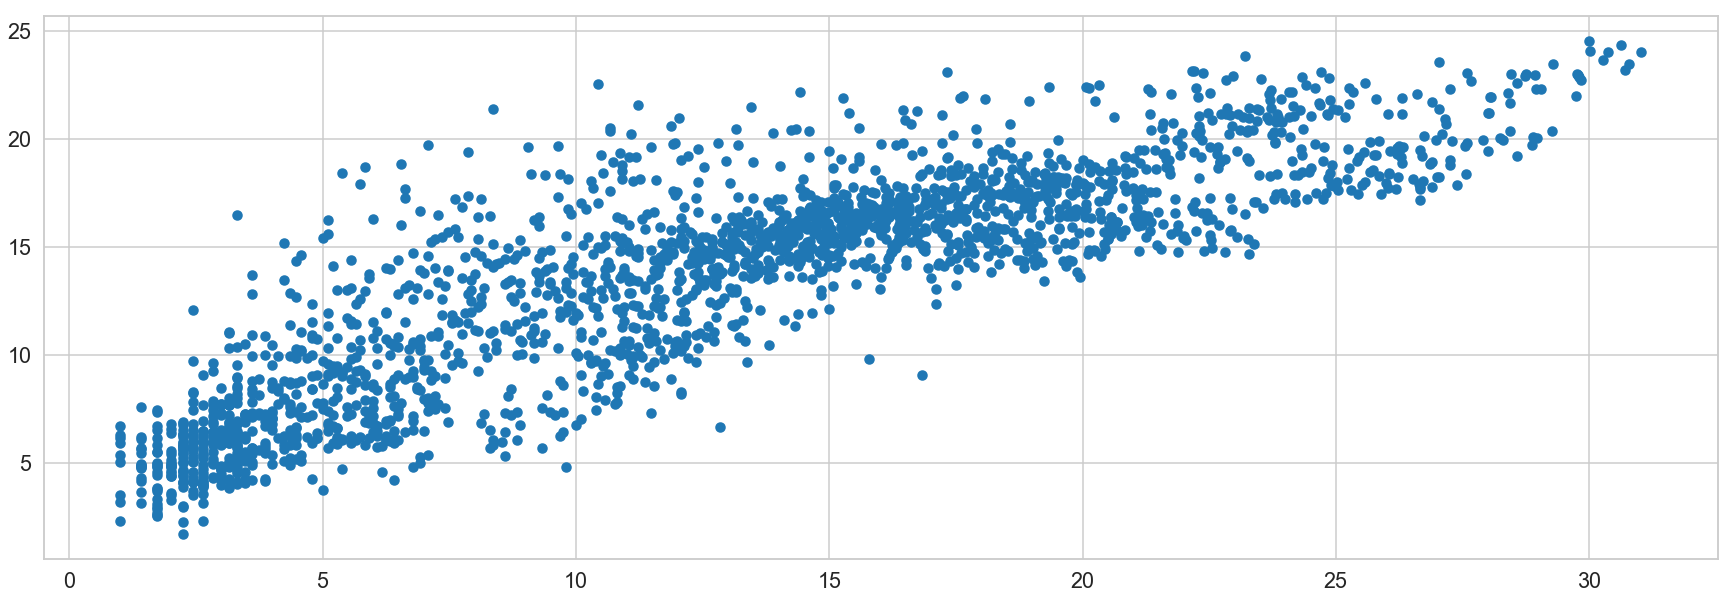

In [110]:
plt.scatter(y_test_p, y_pred)

In [111]:
result = pd.DataFrame({'truth': y_test_p, 'pred': y_pred})
result['abs_diff'] = np.abs(y_test_p - y_pred)

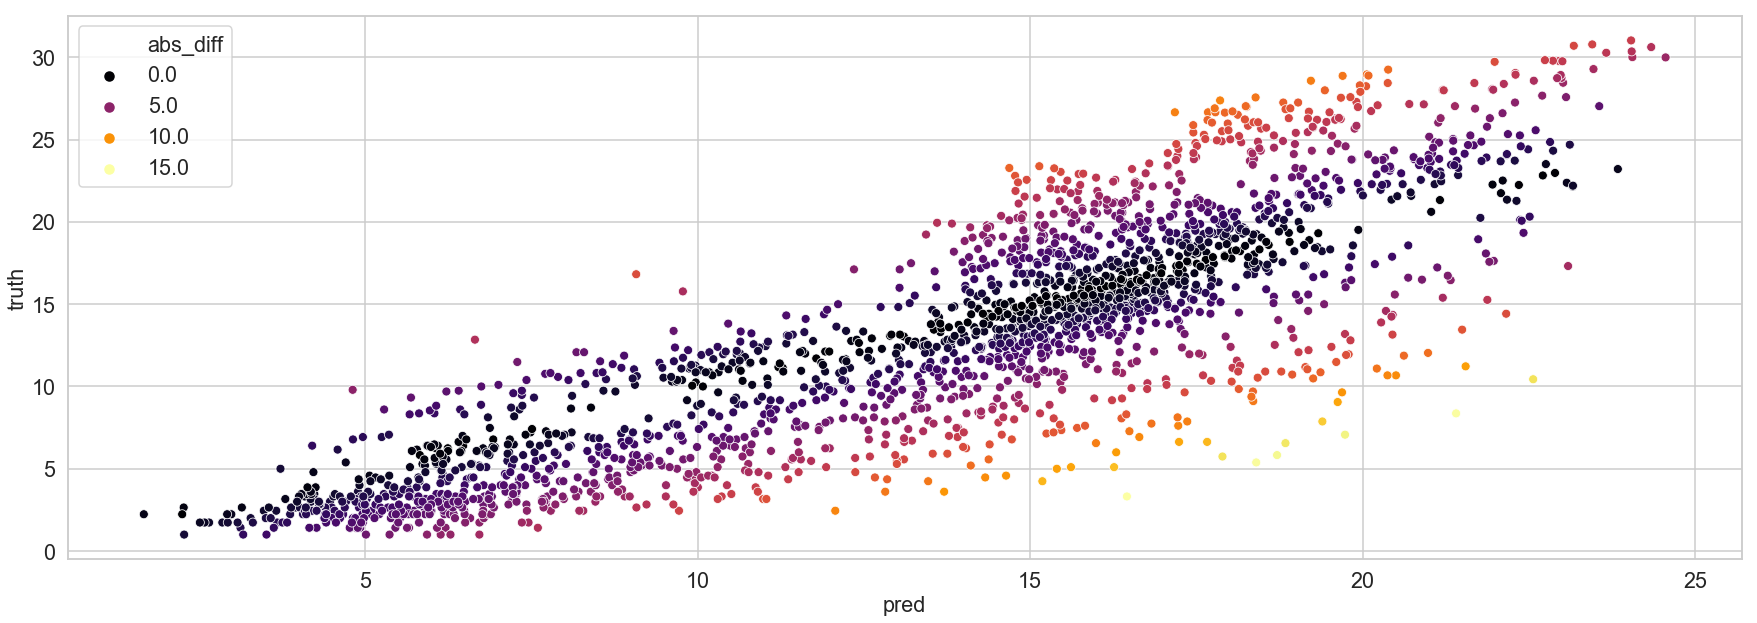

In [112]:
sns.scatterplot(data=result, x="pred", y='truth',
                hue='abs_diff', palette='inferno')

#### For getting the true prediction we should undo the sqrt transformation :

In [113]:
RMSE = np.sqrt(np.mean((y_test_p ** 2 - y_pred ** 2) ** 2))
MSE = RMSE ** 2
print("MSE::{}".format(MSE))
print("RMSE::{}".format(RMSE))

MSE::14903.608336539028
RMSE::122.08033558497056


In [114]:
np.sqrt(np.mean((np.log(y_pred**2+1)-np.log(y_test_p**2+1))**2))

0.8140448701461059

#### As the R^2 score is not good enough in both Lasso and Ridge regression we will try other algorithm. RandomForest seems to be a good match for this dataset, as it does not have many features.

### Modeling using random forest

For the next part we will repartition the data back into 1 partition. This is to simulate a scenario where we want more computational power by using different cores but memory is not an issue. In this case we can scatter the data to all the workers and then train in parallel while keeping the data in every worker as a copy

In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [116]:
gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={"max_depth": (30, 40, 50), "n_estimators": (50, 100, 150)},
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1,
)

In [117]:
# Regular Sklearn
gsc.fit(X_train_p, y_train_p)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   58.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': (30, 40, 50), 'n_estimators': (50, 100, 150)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [118]:
# Using Dask
with joblib.parallel_backend('dask'):
    grid_result = gsc.fit(X_train_p, y_train_p)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.9min finished


This takes longer with Dask, simply because we don't have any more cores than what sklearn was using already, if we had more computers to connect together. This would've been an increase in performance. In this case, the overhead of dask is making it slower

In [119]:
print("Best Score: {}. with Params: {}".format(
    grid_result.best_score_, grid_result.best_params_))

Best Score: -7.814791029098021. with Params: {'max_depth': 30, 'n_estimators': 100}


This grid search was parallelized by Dask, as we're running it on 1 computer it would've been the same as doing sklearn's GridSearchCV and use n_jobs=-1. But if we connect more computers to the scheduler then we would see an increase in performance

I tried connecting a new worker (laptop) to the dask scheduler but it ran into several errors where it couldn't retieve data back and forth and crashed the process.

#### Having done the grid search we will do the model for the best parameters obtained from the grid search.

In [120]:
rf = grid_result.best_estimator_
rf.predict(X_test_p)

array([ 7.2157308 ,  4.20621489,  3.04368655, ..., 11.52419951,
        9.79471171,  7.43572696])

In [121]:
rf.score(X_train_p, y_train_p)

0.9925140277452769

In [122]:
rf.score(X_test_p, y_test_p)

0.842174102968035

In [123]:
y_pred_rf = rf.predict(X_test_p)

In [124]:
RMSE = np.sqrt(np.mean((y_test_p ** 2 - y_pred_rf ** 2) ** 2))
MSE = RMSE ** 2
print("MSE::{}".format(MSE))
print("RMSE::{}".format(RMSE))

MSE::7924.822500169255
RMSE::89.02147212987019


### We got much better result from random forest regressor R^2=0.86 while with linear regression the best R^2 was =0.74
### MSE also for random forest is about half of that for linear regression model.

# SHOTGUN STRATEGY!!!!!

We realized that we can use Dask DataFrames with SKLearn estimators so no need to reuse the pandas one.
We use the Dask Backend in case one of the models can be parallelized

Most of the models here are not parallelizable in an eaasy fashion, so most of them won't see any improvement over sklearn

In [130]:
from sklearn.linear_model import (LinearRegression, ARDRegression,
                                  BayesianRidge, ElasticNet, Lasso, Ridge)
from sklearn.linear_model import (HuberRegressor, PassiveAggressiveRegressor,
                                  SGDRegressor, TheilSenRegressor)

In [131]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [132]:
from sklearn.metrics import median_absolute_error
import time

In [133]:
total_models = pd.DataFrame()

In [135]:
model_names = ['LinearRegression', 'BayesianRidge', 'ElasticNet', 'Lasso', 'Ridge',
               'HuberRegressor', 'PassiveAggressiveRegressor', 'SGDRegressor', 'TheilSenRegressor']
models = [LinearRegression(n_jobs=-1), BayesianRidge(), ElasticNet(),
          Lasso(), Ridge(), HuberRegressor(), PassiveAggressiveRegressor(),
          SGDRegressor(), TheilSenRegressor(n_jobs=-1)]

mse = []
mae = []
msle = []
medae = []
r2 = []
trained_model = []
time_train = []
with joblib.parallel_backend('dask'):
    for model in models:
        start = time.time()
        model.fit(X_train_p, y_train_p)

        mse.append(mean_squared_error(y_test_p, model.predict(X_test_p)))
        mae.append(mean_absolute_error(y_test_p, model.predict(X_test_p)))
        msle.append(mean_squared_log_error(
            y_test_p, abs(model.predict(X_test_p))))
        medae.append(median_absolute_error(y_test_p, model.predict(X_test_p)))
        r2.append(model.score(X_test_p, y_test_p))

        stop = time.time()
        tr_time = stop - start
        time_train.append(tr_time)
        trained_model.append(model)
        print("Model Trained")
models = pd.DataFrame(data={'model': model_names, 'time_train': time_train,
                            'MAE': mae, 'MSE': mse, 'MSLE': msle, 'MEDAE': medae, 'R2': r2})

Model Trained
Model Trained
Model Trained
Model Trained
Model Trained
Model Trained
Model Trained
Model Trained


E:\Anaconda3\envs\basicdata\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
E:\Anaconda3\envs\basicdata\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Model Trained


In [136]:
total_models = pd.concat([total_models, models])

In [137]:
models.sort_values('MSE')

,model,time_train,MAE,MSE,MSLE,MEDAE,R2
0,LinearRegression,0.086806,2.772750e+00,1.281418e+01,0.109338,2.137201e+00,7.471475e-01
1,BayesianRidge,0.724690,2.775480e+00,1.283339e+01,0.109567,2.140399e+00,7.467684e-01
4,Ridge,0.028285,2.776392e+00,1.283966e+01,0.109645,2.142997e+00,7.466446e-01
8,TheilSenRegressor,9.355158,2.922271e+00,1.382490e+01,0.125739,2.323981e+00,7.272036e-01
5,HuberRegressor,1.345567,3.855032e+00,2.366630e+01,0.167725,3.159325e+00,5.330106e-01
3,Lasso,0.025360,6.390862e+00,5.988210e+01,0.536798,5.583920e+00,-1.816086e-01
2,ElasticNet,0.024384,6.390931e+00,5.988345e+01,0.536808,5.583937e+00,-1.816352e-01
6,PassiveAggressiveRegressor,0.075102,1.081541e+01,1.594029e+02,0.932319,1.011274e+01,-2.145378e+00
7,SGDRegressor,0.034137,1.012266e+16,1.026193e+32,1182.759334,1.012271e+16,-2.024909e+30


In [139]:
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor,
                              ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)

In [140]:
model_names = ['AdaBoostRegressor', 'BaggingRegressor', 'ExtraTreesRegressor',
               'GradientBoostingRegressor', 'RandomForestRegressor']
models = [AdaBoostRegressor(), BaggingRegressor(n_jobs=-1), ExtraTreesRegressor(n_jobs=-1),
          GradientBoostingRegressor(), RandomForestRegressor(n_jobs=-1)]

mse = []
mae = []
msle = []
medae = []
r2 = []
trained_model = []
time_train = []

with joblib.parallel_backend('dask'):
    for model in models:
        start = time.time()
        model.fit(X_train_p, y_train_p)

        mse.append(mean_squared_error(y_test_p, model.predict(X_test_p)))
        mae.append(mean_absolute_error(y_test_p, model.predict(X_test_p)))
        msle.append(mean_squared_log_error(
            y_test_p, abs(model.predict(X_test_p))))
        medae.append(median_absolute_error(y_test_p, model.predict(X_test_p)))
        r2.append(model.score(X_test_p, y_test_p))

        stop = time.time()
        tr_time = stop - start
        time_train.append(tr_time)
        trained_model.append(model)
        print("Model Trained")
models = pd.DataFrame(data={'model': model_names, 'time_train': time_train,
                            'MAE': mae, 'MSE': mse, 'MSLE': msle, 'MEDAE': medae, 'R2': r2})

Model Trained
Model Trained


E:\Anaconda3\envs\basicdata\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Trained
Model Trained


E:\Anaconda3\envs\basicdata\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Trained


In [141]:
total_models = pd.concat([total_models, models])

In [142]:
models.sort_values('MSE')

,model,time_train,MAE,MSE,MSLE,MEDAE,R2
2,ExtraTreesRegressor,1.271882,1.569054,5.164954,0.037669,1.073959,0.898084
1,BaggingRegressor,1.640127,1.910837,7.342306,0.047927,1.308684,0.855120
4,RandomForestRegressor,1.122660,2.156704,9.412718,0.058825,1.486539,0.814266
3,GradientBoostingRegressor,1.552765,2.673124,12.463814,0.085754,1.978955,0.754061
0,AdaBoostRegressor,1.474280,4.849399,32.221047,0.316783,4.798336,0.364206


The SVM models perform really bad without a lot of hyper-parameter optimization so we will skip this set of models because it's making Dask sad and slow, so we removed it

In [143]:
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

These models can't be parallelized so there won't be an improvement over sklearn

In [145]:
model_names = ['DecisionTreeRegressor', 'ExtraTreeRegressor']
models = [DecisionTreeRegressor(), ExtraTreeRegressor()]

mse = []
mae = []
msle = []
medae = []
r2 = []
trained_model = []
time_train = []

with joblib.parallel_backend('dask'):
    for model in models:
        start = time.time()
        model.fit(X_train_p, y_train_p)

        mse.append(mean_squared_error(y_test_p, model.predict(X_test_p)))
        mae.append(mean_absolute_error(y_test_p, model.predict(X_test_p)))
        msle.append(mean_squared_log_error(
            y_test_p, abs(model.predict(X_test_p))))
        medae.append(median_absolute_error(y_test_p, model.predict(X_test_p)))
        r2.append(model.score(X_test_p, y_test_p))

        stop = time.time()
        tr_time = stop - start
        time_train.append(tr_time)
        trained_model.append(model)
        # print(model)
models = pd.DataFrame(data={'model': model_names, 'time_train': time_train,
                            'MAE': mae, 'MSE': mse, 'MSLE': msle, 'MEDAE': medae, 'R2': r2})

In [146]:
total_models = pd.concat([total_models, models])

In [147]:
total_models.sort_values('R2', ascending=False)

,model,time_train,MAE,MSE,MSLE,MEDAE,R2
2,ExtraTreesRegressor,1.271882,1.569054e+00,5.164954e+00,0.037669,1.073959e+00,8.980838e-01
1,BaggingRegressor,1.640127,1.910837e+00,7.342306e+00,0.047927,1.308684e+00,8.551198e-01
4,RandomForestRegressor,1.122660,2.156704e+00,9.412718e+00,0.058825,1.486539e+00,8.142659e-01
1,ExtraTreeRegressor,0.103388,2.360256e+00,1.094921e+01,0.072294,1.708579e+00,7.839475e-01
3,GradientBoostingRegressor,1.552765,2.673124e+00,1.246381e+01,0.085754,1.978955e+00,7.540609e-01
0,LinearRegression,0.086806,2.772750e+00,1.281418e+01,0.109338,2.137201e+00,7.471475e-01
1,BayesianRidge,0.724690,2.775480e+00,1.283339e+01,0.109567,2.140399e+00,7.467684e-01
4,Ridge,0.028285,2.776392e+00,1.283966e+01,0.109645,2.142997e+00,7.466446e-01
8,TheilSenRegressor,9.355158,2.922271e+00,1.382490e+01,0.125739,2.323981e+00,7.272036e-01
5,HuberRegressor,1.345567,3.855032e+00,2.366630e+01,0.167725,3.159325e+00,5.330106e-01


# Best Model Optimization

We had to reduce the ammount of parameters here, because using Dask's grid search backend consumes a lot of RAM and it's making the workers crash. So we need to restart workers and such

These use pandas data frames and sklearn to train and gridsearch, but the it's parallelized using dask so it can create several fits in the gridsearch by having several workers do them at the same time. This would be used by scattering the data accross the cluster 

In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor

In [157]:
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [10, 20, 30],
    "max_features": ['sqrt', 'log2'],
}

In [158]:
grid = GridSearchCV(ExtraTreesRegressor(n_jobs=-1), param_grid=param_grid,
                    cv=3, n_jobs=-1, verbose=2)

In [159]:
with joblib.parallel_backend('dask'):
    grid.fit(X_train_p, y_train_p)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.1min finished


In [160]:
grid.best_score_

0.8134728212755958

In [161]:
grid.best_params_

{'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 50}

In [162]:
model = grid.best_estimator_

Here we reuse the Dask DataFrame making a compute (for fun)

In [164]:
model.score(X_test.compute(), y_test.compute())

0.8674448507073682

In [165]:
preds = model.predict(X_test.compute())

In [167]:
mean_absolute_error(y_test.compute(), preds)

1.8724334412083519

In [169]:
RMSE = np.sqrt(np.mean((y_test.compute() ** 2 - preds ** 2) ** 2))
MSE = RMSE ** 2
print("MSE::{}".format(MSE))
print("RMSE::{}".format(RMSE))

MSE::6604.300377378794
RMSE::81.26684672963997


In [170]:
np.sqrt(np.mean((np.log(y_pred**2+1)-np.log(y_test.compute()**2+1))**2))

0.8140448701461059

We need to keep in mind that we are using a single machine which downplays the benefits of dask. This would make a lot more sense if we had connected several workers to the same scheduler.

In [171]:
client.close()